### Spectrum Analyzer Instrument.
* Input: ADC D
* Output: DAC B
* Data chain: ADC -> PFB -> XFFT -> Accumulator.

See examples to extract data from the different points.

In [ ]:
import sys
sys.path.append('./soft')

from top import *
from helpers import *

import numpy as np

import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

In [ ]:
# Load bitstream with custom overlay
soc = TopSoc('./spectrum.bit')

# Print information.
print(soc)

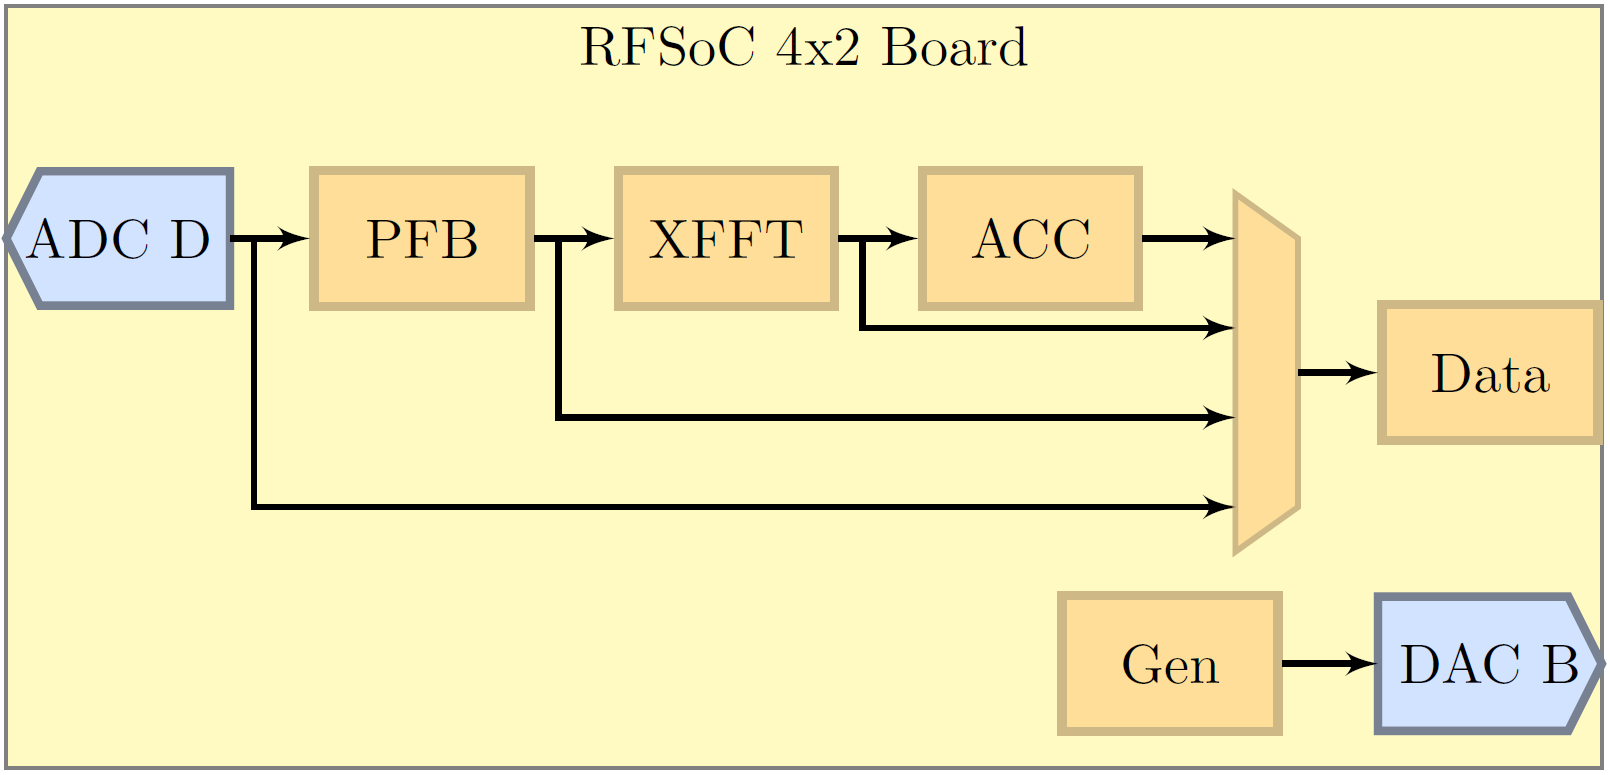

In [45]:
from IPython.display import Image, display
display(Image(filename='images/rfsoc4x2_spectrum.png', embed=True))

In [ ]:
#########################
### Define dual chain ###
#########################
chain = DualChain(soc,soc['analysis'][0],soc['synthesis'][0])

In [ ]:
##########################################
### Simple Sine Loop-back (ADC output) ###
##########################################
# Get data.
[xi,xq] = chain.get_data_adc()
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");
plt.xlim([100,2000])
plt.ylim([-120,-30])

# Time domain signal.
n = np.arange(len(x))
t = n/chain.fs
plt.figure(2,dpi=150)
plt.plot(1000*t,np.real(x))
plt.xlabel("t [ns]");
plt.ylabel("Amplitude [mV]");
plt.xlim([0,100]);

In [ ]:
##########################################
### Simple Sine Loop-back (PFB output) ###
##########################################
fout = 650

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

# Get data.
[xi,xq] = chain.get_bin_pfb(fout)
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(1,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

In [ ]:
##########################################
### Channels Side-by-Side (PFB output) ###
##########################################
# Channels to plot.
K = np.arange(chain.nch)

plt.figure(1,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)  
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15

    # Spectrum.
    w = np.hanning(len(x))
    Aw = len(w)/np.sum(w)
    xw = Aw*x*w
    Y = fftshift(fft(xw)/len(xw))
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

In [ ]:
###########################################
### Simple Sine Loop-back (XFFT output) ###
###########################################
fout = 1100

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

# Get data.
[xi,xq] = chain.get_bin_xfft(fout)
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Scale by FFT length.
x = x/soc.FFT_N

# Spectrum.
Y = fftshift(x)
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(1,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");

In [ ]:
###########################################
### Channels Side-by-Side (XFFT output) ###
###########################################
# Channels to plot.
K = np.arange(chain.nch)

plt.figure(1,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.    
    [xi,xq] = chain.get_bin_xfft(fck+1)    
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15
    
    # Scale by FFT length.
    x = x/soc.FFT_N

    # Spectrum.
    Y = fftshift(x)
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

In [ ]:
##########################################
### Simple Sine Loop-back (ACC output) ###
##########################################
# Number of averages.
N = 10

# Get data.
x = chain.get_data_acc(N)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by FFT length.
x = x/(soc.FFT_N)**2

# Spectrum.
Y = fftshift(x)
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.xlim([100,2000]);
plt.ylim([-120,-20]);